# Ferreira et.al. 2018
Following is its notation and description

|      Parameter       | description                                                  |
| :------------------: | :----------------------------------------------------------- |
|         $K$          | Total number of available price vectors                      |
|         $N$          | Total number of products                                    |
|         $M$          | Total number of kinds of resource                            |
|         $T$          | Total number of periods                                      |
|        $[x]$         | We define $[x]$ as a set, $[x]=\{1,2,\cdots, x\}$            |
|         $i$          | Index of products                                            |
|         $j$          | Index of resources                                           |
|         $t$          | Index of period                                              |
|     $I_j,I_j(t)$     | $I_j$ is the initial inventory for each resource $j\in [M]$, $I_j(t)$ is the inventory at the end of period $t$. $I_j(0)=I_j$ |
|       $a_{ij}$       | When we produced one unit item $i$, it would consume $a_{ij}$ unit $j$ |
|        $c_j$         | we define $c_j=\frac{I_j}{t}$                                |
|        $p_k$         | We define $\{p_1,p_2,\cdots,p_K\}$ as the admissible price vectors, each $p_k$ is a $N\times 1$ vector, specifying the price of each product, $p_k=(p_{1k},\cdots,p_{Nk})$, where $p_{ik}$ is the price of product $i$, for $i\in [N]$. We define $p_{\infty}$ as a "shut-off" price, such that the demand for any product under this price is zero. |
|        $P(t)$        | We denote by $P(t)=(P_1(t),\cdots,P_N(t))$ the prices chosen by the retailer in this period, and require that $P(t)\in \{p_1,p_2,\cdots,p_K,p_{\infty}\}$ |
|        $D(t)$        | We denote by $D(t) = (D_1(t),\cdots,D_N(t))$ the demand of each product at period $t$. We assume that given $P(t)=p_k$, the demand $D(t)$ is sampled from a probability distribution on $\mathbb{R}^{N}_+$ with joint cumulative distribution function (CDF) $F (x_1,\cdots,x_N, pk, \theta )$. $D(t)$ is independent of the history $\mathcal{H}_{t-1}$, given $P(t)$ |
|       $\theta$       | $\theta$ is the parameter of demand distribution, takes values in the parameter space $\Theta\subset\mathbb{R}^l$. The nature would sample $\theta$ from a prior distribution at the beginning form the process. The distribution is assumed to be subexponential; |
|  $\mathcal{H}_{t }$  | $\mathcal{H}_{t}=(P(1),D(1),\cdots,P(t),D(t))$               |
|       $\xi(t)$       | At the beginning of each period $t\in[T]$, the retailer observes some context $\xi(t)$, $\xi(t)$ belongs to some discrete set $\mathcal{X}$. We assume $\xi(t)$ is sampled i.i.d from a known distribution. |
 | $d_{ik}(\xi|\theta)$ | The mean demand of product $i\in [N]$ under price vector $p_k$, $\forall k\in[K]$, given context $\xi$ and parameter $\theta$ |


## 1 st algorithm

We implement the 4th algorithm of Ferreira et.al. 2018

<img src="./Figure/Algorithem_1_of_Ferreira_et_al_2018.png" style="zoom:80%" />

The most difficult task in the implementation of this algorithm is the update rule of posterior. In fact, for most of the prior distribution, it is nearly impossible to derive the explict expression of posterior distribution. Here, we would like to simplify this process.

We generate K * N matrix from beta(1, 1), in other words, uniform distribution in $[0, 1]$. Each entry corresponds to a product in each pricing vector. We let $d_{k,i}$ denote the demand of $i^{th}$ product given $k^{th}$ pricing vector. We assume
$$
\begin{align}
Pr(d_{k,i} = 1) & = \Theta_{k,i}\\
Pr(d_{k,i} = 0) & = 1 - \Theta_{k,i}\\
\end{align}
$$

In this case, it would be quite easy to update the posterior distribution. Assume we adopt $k^{th}$ price vector $p_k$ in period $t_1, t_2, \cdots, t_\tau$, 

For each $k\in [K], i\in [N]$, the poseterior density function of $\Theta_{k,i}$ is 
$$
\begin{align}
f(\theta_{k,i} | (p^{(t_1)}_{k},d^{(t_1)}_k),\cdots, (p^{(t_\tau)}_{k},d^{(t_\tau)}_k)) 
& = \frac{Pr(d^{(t_1)}_k,\cdots, ,d^{(t_\tau)}_k \ | \ \theta_{k,i}) * 1}{\int_{0}^{1}Pr(d^{(t_1)}_k,\cdots, ,d^{(t_\tau)}_k \ | \ \theta)*1d\theta}\\
&=\frac{\prod_{j=1}^\tau Pr(d^{(t_j)}_k| \ \theta_{k,i}) * 1}{\int_{0}^{1}\prod_{j=1}^\tau Pr(d^{(t_j)}_k| \ \theta)*1d\theta}\\
&=\frac{\theta_{k,i}^{\sum_{j=1}^\tau d^{(t_j)}_k} (1-\theta_{k,i})^{\tau-\sum_{j=1}^\tau d^{(t_j)}_k}}{\int_{0}^{1}\theta^{\sum_{j=1}^\tau d^{(t_j)}_k} (1-\theta)^{\tau-\sum_{j=1}^\tau d^{(t_j)}_k}d\theta}\\
&=beta(\sum_{j=1}^\tau d^{(t_j)}_k, \tau-\sum_{j=1}^\tau d^{(t_j)}_k)
\end{align}
$$

$d^{(i)}_j$ is the demand of $j^{th}$ product in $i^{th}$ period

Well, there are also tough problems. That is, there would be counter-intuitive random number. For example, **higher price lead to higher demand**. But anyway, I tried my best to find a suitable prior distribution, but I failed to do so. So I decided to just use this easier one.

In [1]:
%reset -f
import numpy as np
import pandas as pd # we would restore our result in csv file .\\Result_Ferreira et.al. 2018 Algorithm 1\\
import datetime

import pyscipopt
from pyscipopt import quicksum

random_seed = 888
np.random.seed(random_seed)

In [2]:
# Generate parameters
# the maximum value of np.random.randint(low, high) would be high - 1
K = np.random.randint(low = 2, high = 10) # Total number of available price vectors, 
N = np.random.randint(low = 2, high = 10) # Total number of products
M = np.random.randint(low = 2, high = 10) # Total number of kinds of resource
T = 1000 # Total number of periods

# each row represent an admissible pricing strategy
P_list = np.float64(np.random.randint(low = 1, high = 10, size = (K, N)))

# initialize inventory
# c is the limitation of resources in each round
c = np.random.randint(low = 10, high = 15, size = M)
I_0 = c * T

# initialize a_ij
# A is the cost of each product
A = np.float64(np.random.randint(low = 10, high = 15, size = (N,M)))

# initialize real parameter theta
theta = np.random.beta(a = 200, b = 100, size = (K,N))

In [3]:
class FerreiraAgent:
    # this agent would adopt the 1st algorithm
    def __init__(self, K, N, M, T, P_list, A, I_0):
        self.K = K
        self.N = N
        self.M = M
        self.T = T
        self.P_list = P_list
        self.A = A
        self.I_0 = I_0
        
        # initialize history
        self.H_P = np.zeros(shape = T) # the index of pricing vector we used in each period
        self.H_D = np.zeros(shape = (T, N)) # the demand of products in each period  
        self.H_I = np.zeros(shape = (T + 1, M)) # avaliable remained inventory in each period
        self.H_I[0, :] = np.float64(I_0)
        self.H_reward = np.zeros(T) # the reward in each period
        self.H_bestX = np.zeros(shape = (T, K + 1)) # the best solution in each optimization
        
        # each realization of price vector, index of period,
        # corresponds to a estimate of theta
        self.H_alpha = np.zeros(shape = (T + 1,K,N))
        self.H_beta = np.zeros(shape = (T + 1,K,N))
        self.H_alpha[0, :, :] = 1 * np.ones(shape = (K,N))
        self.H_beta[0, :, :] = 1 * np.ones(shape = (K,N))

        # initialize the constraint value in each round
        # M kinds of resources correspond to M constraints, and one more constraint is x1 + ... + xN <=1
        self.H_constraint_value = np.zeros(shape = (T, M + 1))
        
        # estimated theta in each round
        self.H_theta = np.zeros(shape = (T,K,N))
        
        # initialize the index of period
        self.t = 1
        
        # initialize the average consumption of resource
        self.c = I_0 / T
        
    def Action(self):
        # vectorize beta sample function to accelerate
        mybeta = np.vectorize(np.random.beta)
        
        if not all(self.H_I[self.t - 1] >= 0):
            # resource are not enough
            price_offered_index = self.K + 1
            self.H_P[self.t - 1] = price_offered_index # record the index of offered price
            return price_offered_index
        
        # first step, sample from posterior distribution
        # H_alpha[t-1, :, :], H_beta[t-1, :, :] is the history data from 0 to t
        # H_theta[t-1, :, :] is the sample theta we used in round t
        self.H_theta[t-1, :, :] = mybeta(self.H_alpha[t-1, :, :], self.H_beta[t-1, :, :])
        
        # first step, calculate the mean demand given sample theta
        demand_mean = self.H_theta[t-1, :, :]
        
        # second step, optimize a linear function
        model = pyscipopt.Model("Optimization in Rount {:d}".format(t))
        # generate decision variable
        x = {}
        for xindex in range(1, K+1):
            x[xindex] = model.addVar(vtype="C", lb = 0, ub = 1, name="x{:d}".format(xindex))

        # second step, generate object function
        obj_coefficient = np.sum(demand_mean * self.P_list, axis = 1)# obj_coefficient[k] = $\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1}$
        model.setObjective(quicksum(x[xindex]*obj_coefficient[xindex-1] for xindex in range(1, K+1)), "maximize")
        # objective = $\sum_{k=1}^K(\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1})x_{k}$

        # second step, add constraint x_1+...+x_k<=1
        constraint_index = {}
        constraint_index[0] = model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

        # second step, for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
        for jj in range(1, M+1):
            con_coefficient = self.A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
            constraint_index[jj] = model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= self.c[jj - 1])

        # second step, optimize the problem
        model.optimize()
        bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
        for xindex in range(1,K+1):
            bestx[xindex - 1] = model.getVal(x[xindex])
        bestx[K] = 1 - np.sum(bestx[0:K])
        eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
        bestx = np.array([eliminate_error(x) for x in bestx])
        bestx = bestx / np.sum(bestx)
        
        # third step, offer price
        price_offered_index = np.random.choice(np.arange(1, K + 2), p = bestx)

        # fourth step, update estimate of parameter
        self.H_P[self.t - 1] = price_offered_index # record the index of offered price

        # fourth step, record the constraint value in optimization
        self.H_constraint_value[self.t - 1, 0] = np.sum(bestx[0:K])
        for jj in range(1, M+1):
            con_coefficient = np.array(list(model.getValsLinear(constraint_index[jj]).values()))
            self.H_constraint_value[self.t - 1, jj] = np.sum(bestx[0:K] * con_coefficient)

        # fourth step, record the optimal solution in this round
        self.H_bestX[self.t - 1, :] = bestx
        
        return price_offered_index
    
    def Update(self, demand):
        # record the realized demand
        self.H_D[self.t - 1, :] = demand 
        
        # record the reward
        price_offered_index = np.int64(self.H_P[self.t - 1])# record the index of offered price
        if price_offered_index < K + 1:
            self.H_reward[self.t - 1] = self.P_list[price_offered_index - 1, :].dot(self.H_D[self.t - 1, :]) 
        else: # the demand must be zero
            self.H_reward[self.t - 1] = 0
            
        # update the remaining inventory
        self.H_I[self.t] = self.H_I[self.t - 1] - np.transpose(self.A).dot(self.H_D[self.t - 1, :])
        
        # update the estimation of alpha and beta
        if price_offered_index < K + 1:
            # if demand = 1, then alpha plus 1; if demand = 0, then alpha remain unchanged
            self.H_alpha[self.t, :, :] = self.H_alpha[self.t - 1, :, :]
            self.H_alpha[self.t, price_offered_index - 1, :] = self.H_alpha[self.t, price_offered_index - 1, :] + self.H_D[self.t - 1, :]

            # if demand = 1, then beta remained unchanged; if demand = 0, then beta plus 1
            self.H_beta[self.t, :, :] = self.H_beta[self.t - 1, :, :]
            self.H_beta[self.t, price_offered_index - 1, :] = self.H_beta[self.t - 1, price_offered_index - 1, :] + np.ones(N) - self.H_D[self.t - 1, :]
        else: # the demand must be zero, then all the estimate remain unchanged
            self.H_alpha[t, :, :] = self.H_alpha[t - 1, :, :]
            self.H_beta[t, :, :] = self.H_beta[t - 1, :, :]
            
        # update the index of period
        self.t = self.t + 1

In [4]:
class UniformAgent:
    # this agent would uniformly pick pricing vector
    def __init__(self, K, N, M, T, P_list, A, I_0):
        self.K = K
        self.N = N
        self.M = M
        self.T = T
        self.P_list = P_list
        self.A = A
        self.I_0 = I_0
        
        # initialize history
        self.H_P = np.zeros(shape = T) # the index of pricing vector we used in each period
        self.H_D = np.zeros(shape = (T, N)) # the demand of products in each period  
        self.H_I = np.zeros(shape = (T + 1, M)) # avaliable remained inventory in each period
        self.H_I[0, :] = np.float64(I_0)
        self.H_reward = np.zeros(T) # the reward in each period
        
        # initialize the index of period
        self.t = 1
        
    def Action(self):
        # vectorize beta sample function to accelerate
        mybeta = np.vectorize(np.random.beta)
        
        if not all(self.H_I[self.t - 1] >= 0):
            # resource are not enough
            price_offered_index = self.K + 1
            self.H_P[self.t - 1] = price_offered_index # record the index of offered price
            return price_offered_index
        
        price_offered_index = np.random.randint(low = 1, high = self.K + 2)
        # the maximum value of np.random.randint(low, high) would be high - 1
        self.H_P[self.t - 1] = price_offered_index
        return price_offered_index
    
    def Update(self, demand):
        # record the realized demand
        self.H_D[self.t - 1, :] = demand 
        
        # record the reward
        price_offered_index = np.int64(self.H_P[self.t - 1])# record the index of offered price
        if price_offered_index < K + 1:
            self.H_reward[self.t - 1] = self.P_list[price_offered_index - 1, :].dot(self.H_D[self.t - 1, :]) 
        else: # the demand must be zero
            self.H_reward[self.t - 1] = 0
            
        # update the remaining inventory
        self.H_I[self.t] = self.H_I[self.t - 1] - np.transpose(self.A).dot(self.H_D[self.t - 1, :])
            
        # update the index of period
        self.t = self.t + 1

In [5]:
class Environment:
    # we use an object as environment to cooperate with agents
    def __init__(self, theta, K, N):
        self.theta = theta
        self.K = K
        self.N = N
    
    def Response(self, price_offered_index):
        # vectorize binomial sample function to accelerate
        mybinomial = np.vectorize(np.random.binomial)
        if price_offered_index < self.K + 1:
            demand = mybinomial(np.ones(self.N), theta[price_offered_index - 1, :]) # record the realization of demand
        else: # the demand must be zero
            demand = np.zeros(self.N) 
        return demand

In [6]:
# Carry on experiments
random_seed = 12345
np.random.seed(random_seed)

exp_num = 5

rewardferreira = np.zeros(shape = (exp_num, T))
rewarduniform = np.zeros(shape = (exp_num, T))

for exp_index in range(exp_num):
    ferreiraagent = FerreiraAgent(K, N, M, T, P_list, A, I_0)
    env = Environment(theta, K, N)
    for t in range(1, T+1):
        price_offered_index = ferreiraagent.Action()
        demand = env.Response(price_offered_index)
        ferreiraagent.Update(demand)
    rewardferreira[exp_index, :] = ferreiraagent.H_reward
        
    uniformagent = UniformAgent(K, N, M, T, P_list, A, I_0)
    env = Environment(theta, K, N)
    for t in range(1, T+1):
        price_offered_index = uniformagent.Action()
        demand = env.Response(price_offered_index)
        uniformagent.Update(demand)
    rewarduniform[exp_index, :] = uniformagent.H_reward

rewardferreira = np.mean(rewardferreira, axis = 0)
rewarduniform = np.mean(rewarduniform, axis = 0)

In [7]:
# calculate the benchmark
model = pyscipopt.Model("Optimization in Rount {:d}".format(t))

x = {}
for xindex in range(1, K+1):
    x[xindex] = model.addVar(vtype="C", lb = 0, ub = 1, name="x{:d}".format(xindex))

# Generate object function
demand_mean = theta
obj_coefficient = np.sum(demand_mean *  P_list, axis = 1)# obj_coefficient[k] = $\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1}$
model.setObjective(quicksum(x[xindex]*obj_coefficient[xindex-1] for xindex in range(1, K+1)), "maximize")
# objective = $\sum_{k=1}^K(\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1})x_{k}$

# add constraint x_1+...+x_k<=1
constraint_index = {}
constraint_index[0] = model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

# add, constraint for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
for jj in range(1, M+1):
    con_coefficient = A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
    constraint_index[jj] = model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= c[jj - 1])

# optimize the problem
model.optimize()

# get the best solution
bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
for xindex in range(1,K+1):
    bestx[xindex - 1] = model.getVal(x[xindex])
bestx[K] = 1 - np.sum(bestx[0:K])
eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
bestx = np.array([eliminate_error(x) for x in bestx])
bestx = bestx / np.sum(bestx)

Opt = model.getObjVal()

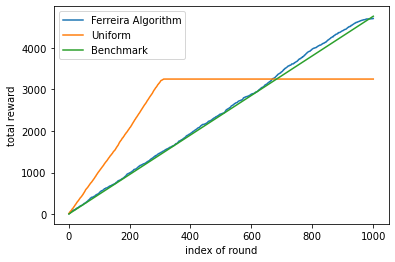

In [8]:
import matplotlib.pyplot as plt

bestreward = Opt * np.ones(T)
plt.figure()
plt.plot(range(1, T + 1), np.cumsum(rewardferreira))
plt.plot(range(1, T + 1), np.cumsum(rewarduniform))
plt.plot(range(1, T + 1), np.cumsum(bestreward))
plt.xlabel("index of round")
plt.ylabel("total reward")
plt.legend(["Ferreira Algorithm", "Uniform", "Benchmark"])

In [9]:
# bestreward = Opt * np.ones(T)
# plt.figure()
# plt.plot(range(1, T + 1), np.cumsum(ferreiraagent.H_reward))
# plt.plot(range(1, T + 1), np.cumsum(uniformagent.H_reward))
# plt.plot(range(1, T + 1), np.cumsum(bestreward))
# plt.xlabel("index of round")
# plt.ylabel("total reward")
# plt.legend(["Ferreira Algorithm", "Uniform", "Benchmark"])

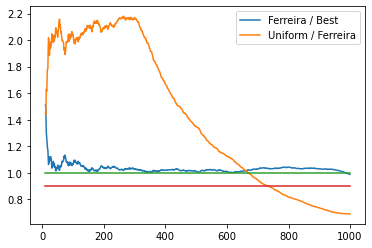

In [10]:
plt.figure()
plt.plot(range(10, T), np.cumsum(rewardferreira)[10:T] / np.cumsum(bestreward)[10:T])
plt.plot(range(10, T), np.cumsum(rewarduniform)[10:T] / np.cumsum(rewardferreira)[10:T])
plt.legend(["Ferreira / Best", "Uniform / Ferreira"])
plt.plot(range(10, T), np.ones(T)[10:T])
plt.plot(range(10, T), 0.9 * np.ones(T)[10:T])
plt.show()

In [11]:
np.sum(rewardferreira)

4704.6

In [12]:
Opt * T

4758.011663603385

In [5]:
# generate the csv data file and restore it into csv file
from datetime import datetime
moment = str(datetime.now()).replace(':', '-').replace(' ', '_')[:-7]
# the value of moment:  '2021-10-21_11-39-24', we used this varibale to name our files

# we firstly input the parameter into txt file
prameter_filename = moment + "_K-{:d}_N-{:d}_M-{:d}_T-{:d}_randomseed-{:d}_ParameterList.txt".format(K, N, M, T, random_seed)
with open(".\\Result_Ferreira et.al. 2018 Algorithm 1\\" + prameter_filename, 'w') as f:
    f.write("K = {:d}\n".format(K))
    f.write("N = {:d}\n".format(N))
    f.write("M = {:d}\n".format(M))
    f.write("randomseed = {:d}\n".format(random_seed))
    
    f.write("-----Admissible Prive Vector------\n")
    for kindex in range(K):
        f.write("Price vector {:d} : {:s}\n".format(kindex, str(P_list[kindex, :])))
                
    f.write("-----Initial Inventory------\n")
    f.write("Initial Inventory: {:s}\n".format(str(I_0)))
                
    f.write("-----Resource Consumption------\n")
    for nindex in range(N):
        f.write("Cost of resource of product {:d}: {:s}\n".format(nindex + 1, str(A[nindex, :])))
    
    f.write("-----Resouce Constraint in each round------\n")
    for nindex in range(N):
        f.write("c : {:s}\n".format(str(c)))
                
    f.write("-----Real theta------\n")
    for kindex in range(K):
        f.write("Given price vector {:d}, the real theta is {:s}\n".format(kindex + 1, str(theta[kindex, :])))
        
# then we input the experiment into csc file, we use period as index
data = pd.DataFrame({"Pricing_index": H_P, "Reward": H_reward})
data['Period_index'] = range(1, T+1)
# add the demand of each product
data = pd.concat([data, pd.DataFrame(H_D, columns = ["product_{:d}_demand".format(nindex) for nindex in range(1,N+1)])], axis = 1) 
# add the remain invetory of each resource
data = pd.concat([data, pd.DataFrame(H_I[0:T, :], columns = ["resouce_{:d}".format(mindex) for mindex in range(1,M+1)])], axis = 1)
# add the constraint value
data = pd.concat([data, pd.DataFrame(H_constraint_value[0:T, :], columns = ["constraint_{:d}".format(conindex) for conindex in range(0,M+1)])], axis = 1)
# add the best solution in each round
data = pd.concat([data, 
                  pd.DataFrame(H_bestX,\
                              columns = ["use_price_index_{:d}".format(kindex) for kindex in range(1,K+1)] + ["use_infinite_price"])],
                  axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_alpha[0:T, :, :], newshape =(T, K * N)),
                             columns = ["alpha_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_beta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["beta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of theta
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_theta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["theta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
exp_filename = moment + "_K-{:d}_N-{:d}_M-{:d}_T-{:d}_randomseed-{:d}_Experiment.csv".format(K, N, M, T, random_seed)
data.to_csv(".\\Result_Ferreira et.al. 2018 Algorithm 1\\" + exp_filename, index = False)

In [6]:
# clear the memory
H_reward = np.zeros(T) # the reward in each period
H_bestX = np.zeros(shape = (T, K + 1)) # the best solution in each optimization
H_P = np.zeros(shape = T) # the index of pricing vector we used in each period
H_D = np.zeros(shape = (T, N)) # the demand of products in each period  
H_I = np.zeros(shape = (T + 1, M)) # avaliable inventory in each period
H_I[0, :] = np.float64(I_0)

In [7]:
# if we replace step 1 with true theta
for t in range(1, T+1):
    # first step, sample from posterior distribution
    # H_alpha[t-1, :, :], H_beta[t-1, :, :] is the history data from 0 to t
    # H_theta[t-1, :, :] is the sample theta we used in round t
#     H_theta[t-1, :, :] = mybeta(H_alpha[t-1, :, :], H_beta[t-1, :, :])

    # first step, calculate the mean demand given sample theta
    demand_mean = theta

    # second step, optimize a linear function
    model = pyscipopt.Model("Optimization in Rount {:d}".format(t))
    # generate decision variable
    x = {}
    for xindex in range(1, K+1):
        x[xindex] = model.addVar(vtype="C", lb = 0, ub = 1, name="x{:d}".format(xindex))

    # second step, generate object function
    obj_coefficient = np.sum(demand_mean *  P_list, axis = 1)# obj_coefficient[k] = $\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1}$
    model.setObjective(quicksum(x[xindex]*obj_coefficient[xindex-1] for xindex in range(1, K+1)), "maximize")
    # objective = $\sum_{k=1}^K(\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1})x_{k}$

#     # second step, add constraint x_1+...+x_k<=1
#     model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

#     # second step, for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
#     for jj in range(1, M+1):
#         # size(A) = [N, M], size(demand_mean) = [K, N]
#         con_coefficient = A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
#         model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= c[jj - 1])

#     # second step, optimize the problem
#     model.optimize()
#     bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
#     for xindex in range(1,K+1):
#         bestx[xindex - 1] = model.getVal(x[xindex])
#     bestx[K] = 1 - np.sum(bestx[0:K])
#     eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
#     bestx = np.array([eliminate_error(x) for x in bestx])
#     bestx = bestx / np.sum(bestx)

#     # third step, offer price
#     price_offered_index = np.random.choice(np.arange(1, K + 2), p = bestx)

    # second step, add constraint x_1+...+x_k<=1
    constraint_index = {}
    constraint_index[0] = model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

    # second step, for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
    for jj in range(1, M+1):
        # size(A) = [N, M], size(demand_mean) = [K, N]
        con_coefficient = A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
        constraint_index[jj] = model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= c[jj - 1])

    # second step, optimize the problem
    model.optimize()
    bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
    for xindex in range(1,K+1):
        bestx[xindex - 1] = model.getVal(x[xindex])
    bestx[K] = 1 - np.sum(bestx[0:K])
    eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
    bestx = np.array([eliminate_error(x) for x in bestx])
    bestx = bestx / np.sum(bestx)
    
    # third step, offer price
    price_offered_index = np.random.choice(np.arange(1, K + 2), p = bestx)

    # fourth step, update estimate of parameter
    H_P[t - 1] = price_offered_index # record the index of offered price
    
    # fourth step, record the constraint value in optimization
    H_constraint_value[t - 1, 0] = np.sum(bestx[0:K])
    for jj in range(1, M+1):
        con_coefficient = np.array(list(model.getValsLinear(constraint_index[jj]).values()))
        H_constraint_value[t - 1, jj] = np.sum(bestx[0:K] * con_coefficient)

    # fourth step, update estimate of parameter
    H_P[t - 1] = price_offered_index # record the index of offered price

    # fourth step, record the optimal solution in this round
    H_bestX[t - 1, :] = bestx

    # fourth step, record the realization of demand
    if price_offered_index < K + 1:
        H_D[t - 1, :] = mybinomial(np.ones(N), theta[price_offered_index - 1, :]) # record the realization of demand
    else: # the demand must be zero
        H_D[t - 1, :] = np.zeros(N)

    # fourth step, record the reward in this period
    if price_offered_index < K + 1:
        H_reward[t - 1] = P_list[price_offered_index - 1, :].dot(H_D[t - 1, :])  # record the realization of demand
    else: # the demand must be zero
        H_reward[t - 1] = 0

    # fourth step, record the remain inventory, size(A) = [N, M]
    H_I[t, :] = H_I[t - 1, :] - np.transpose(A).dot(H_D[t - 1, :])
    if not all(H_I[t, :] >= 0):
        break

print("Total reward of known distribution: {:f}".format(np.sum(H_reward)))

Total reward of known distribution: 4254.000000


In [8]:
# then input the experiment into csc file, we use period as index
data = pd.DataFrame({"Pricing_index": H_P, "Reward": H_reward})
data['Period_index'] = range(1, T+1)
# add the demand of each product
data = pd.concat([data, pd.DataFrame(H_D, columns = ["product_{:d}_demand".format(nindex) for nindex in range(1,N+1)])], axis = 1) 
# add the remain invetory of each resource
data = pd.concat([data, pd.DataFrame(H_I[0:T, :], columns = ["resouce_{:d}".format(mindex) for mindex in range(1,M+1)])], axis = 1) 
# add the constraint value
data = pd.concat([data, pd.DataFrame(H_constraint_value[0:T, :], columns = ["constraint_{:d}".format(conindex) for conindex in range(0,M+1)])], axis = 1)
# add the best solution in each round
data = pd.concat([data, 
                  pd.DataFrame(H_bestX,\
                              columns = ["use_price_index_{:d}".format(kindex) for kindex in range(1,K+1)] + ["use_infinite_price"])],
                  axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_alpha[0:T, :, :], newshape =(T, K * N)),
                             columns = ["alpha_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_beta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["beta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of theta
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_theta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["theta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
exp_filename = moment + "_K-{:d}_N-{:d}_M-{:d}_T-{:d}_randomseed-{:d}_RealThetaExperiment.csv".format(K, N, M, T, random_seed)
data.to_csv(".\\Result_Ferreira et.al. 2018 Algorithm 1\\" + exp_filename, index = False)

## 2 nd algorithm

We implement the 4th algorithm of Ferreira et.al. 2018

<img src="./Figure/Algorithem_2_of_Ferreira_et_al_2018.png" style="zoom:80%" />

$c_j(t) = \frac{I_j(t-1)}{T-t+1}$

In [9]:
%reset -f
import numpy as np
import pandas as pd

import pyscipopt
from pyscipopt import quicksum

random_seed = 12345
np.random.seed(random_seed)

In [10]:
# Generate parameters
K = np.random.randint(low = 1, high = 5) # Total number of available price vectors
N = np.random.randint(low = 1, high = 5) # Total number of products
M = np.random.randint(low = 1, high = 5) # Total number of kinds of resource
T = 1000 # Total number of periods

# generate the demand 

# each row represent an admissible pricing strategy
P_list = np.float64(np.random.randint(low = 1, high = 10, size = (K, N)))

# initialize inventory
I_0 = np.float64(np.random.randint(low = 9000, high = 11000, size = M))
c = np.zeros(shape = (T, M)) # we would update c in each period

# initialize a_ij
A = np.float64(np.random.randint(low = 5, high = 15, size = (N,M)))

# initialize real parameter theta
theta = np.random.beta(a = 1, b = 1, size = (K,N))

# initialize history
H_P = np.zeros(shape = T) # the index of pricing vector we used in each period
H_D = np.zeros(shape = (T, N)) # the demand of products in each period  

H_I = np.zeros(shape = (T + 1, M)) # avaliable inventory in each period
H_I[0, :] = np.float64(I_0)

H_bestX = np.zeros(shape = (T, K + 1)) # the best solution in each optimization

H_reward = np.zeros(T) # the reward in each period

# each realization of price vector, index of period,
# corresponds to a estimate of theta
H_alpha = np.zeros(shape = (T + 1,K,N))
H_beta = np.zeros(shape = (T + 1,K,N))
H_alpha[0, :, :] = 1*np.ones(shape = (K,N))
H_beta[0, :, :] = 1*np.ones(shape = (K,N))

# initialize the constraint value in each round
# M kinds of resources correspond to M constraints, and one more constraint is x1 + ... + xN <=1
H_constraint_value = np.zeros(shape = (T, M + 1))

# vectorize beta sample function to accelerate
mybeta = np.vectorize(np.random.beta)
H_theta = np.zeros(shape = (T,K,N))

# vectorize binomial sample function to accelerate
mybinomial = np.vectorize(np.random.binomial)

In [11]:
# implementation of algorithm 2
for t in range(1, T+1):
    # first step, sample from posterior distribution
    # H_alpha[t-1, :, :], H_beta[t-1, :, :] is the history data from 0 to t
    # H_theta[t-1, :, :] is the sample theta we used in round t
    H_theta[t-1, :, :] = mybeta(H_alpha[t-1, :, :], H_beta[t-1, :, :])

    # first step, calculate the mean demand given sample theta
    demand_mean = H_theta[t-1, :, :]

    # second step, optimize a linear function
    model = pyscipopt.Model("Optimization in Rount {:d}".format(t))
    # generate decision variable
    x = {}
    for xindex in range(1, K+1):
        x[xindex] = model.addVar(vtype="C", lb = 0, ub = 1, name="x{:d}".format(xindex))

    # second step, generate object function
    obj_coefficient = np.sum(demand_mean *  P_list, axis = 1)# obj_coefficient[k] = $\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1}$
    model.setObjective(quicksum(x[xindex]*obj_coefficient[xindex-1] for xindex in range(1, K+1)), "maximize")
    # objective = $\sum_{k=1}^K(\sum_{i=1}^N d_{i,k+1}(t)p_{i,k+1})x_{k}$

#     # second step, add constraint x_1+...+x_k<=1
#     model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

#     # second step, for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
#     c[t - 1, :] = H_I[t - 1, :] / (T - t + 1)
#     for jj in range(1, M+1):
#         # size(A) = [N, M], size(demand_mean) = [K, N]
#         con_coefficient = A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
#         model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= c[t - 1, jj - 1])

#     # second step, optimize the problem
#     model.optimize()
#     bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
#     for xindex in range(1,K+1):
#         bestx[xindex - 1] = model.getVal(x[xindex])
#     bestx[K] = 1 - np.sum(bestx[0:K])
#     eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
#     bestx = np.array([eliminate_error(x) for x in bestx])
#     bestx = bestx / np.sum(bestx)


#     # third step, offer price
#     price_offered_index = np.random.choice(np.arange(1, K + 2), p = bestx)

    # second step, add constraint x_1+...+x_k<=1
    constraint_index = {}
    constraint_index[0] = model.addCons(quicksum(x[xindex] for xindex in range(1, K+1)) <= 1)

    # second step, for each resources, we require \sum_{k=1}^K\sum_{i=1}^N d_{i,k}a_{i,j}x_l<=c_j
    c[t - 1, :] = H_I[t - 1, :] / (T - t + 1)
    for jj in range(1, M+1):
        # size(A) = [N, M], size(demand_mean) = [K, N]
        con_coefficient = A[:, jj - 1].dot(np.transpose(demand_mean))# con_coefficient[k] = $\sum_{i=1}^N a_{i,j}d_{i,k+1}$
        constraint_index[jj] = model.addCons(quicksum(x[xindex] * con_coefficient[xindex - 1] for xindex in range(1, K+1)) <= c[t - 1, jj - 1])

    # second step, optimize the problem
    model.optimize()
    bestx = np.zeros(K+1) # p_{K+1} would force the demand be zero
    for xindex in range(1,K+1):
        bestx[xindex - 1] = model.getVal(x[xindex])
    bestx[K] = 1 - np.sum(bestx[0:K])
    eliminate_error = lambda x: 0 if np.abs(x) < 1e-10 else x #there would be numerical error in the best solution
    bestx = np.array([eliminate_error(x) for x in bestx])
    bestx = bestx / np.sum(bestx)
    
    # third step, offer price
    price_offered_index = np.random.choice(np.arange(1, K + 2), p = bestx)

    # fourth step, update estimate of parameter
    H_P[t - 1] = price_offered_index # record the index of offered price
    
    # fourth step, record the constraint value in optimization
    H_constraint_value[t - 1, 0] = np.sum(bestx[0:K])
    for jj in range(1, M+1):
        con_coefficient = np.array(list(model.getValsLinear(constraint_index[jj]).values()))
        H_constraint_value[t - 1, jj] = np.sum(bestx[0:K] * con_coefficient)

    # fourth step, update estimate of parameter
    H_P[t - 1] = price_offered_index # record the index of offered price

    # fourth step, record the optimal solution in this round
    H_bestX[t - 1, :] = bestx

    # fourth step, record the realization of demand
    if price_offered_index < K + 1:
        H_D[t - 1, :] = mybinomial(np.ones(N), theta[price_offered_index - 1, :]) # record the realization of demand
    else: # the demand must be zero
        H_D[t - 1, :] = np.zeros(N)

    # fourth step, record the reward in this period
    if price_offered_index < K + 1:
        H_reward[t - 1] = P_list[price_offered_index - 1, :].dot(H_D[t - 1, :])  # record the realization of demand
    else: # the demand must be zero
        H_reward[t - 1] = 0

    # fourth step, record the remain inventory, size(A) = [N, M]
    H_I[t] = H_I[t - 1] - np.transpose(A).dot(H_D[t - 1, :])
    if not all(H_I[t] >= 0):
        break

    # fourth step, record the new estimate of alpha and beta
    if price_offered_index < K + 1:
        # if demand = 1, then alpha plus 1; if demand = 0, then alpha remain unchanged
        H_alpha[t, :, :] = H_alpha[t - 1, :, :]
        H_alpha[t, price_offered_index - 1, :] = H_alpha[t, price_offered_index - 1, :] + H_D[t - 1, :]

        # if demand = 1, then beta remained unchanged; if demand = 0, then beta plus 1
        H_beta[t, :, :] = H_beta[t - 1, :, :]
        H_beta[t, price_offered_index - 1, :] = H_beta[t - 1, price_offered_index - 1, :] + np.ones(N) - H_D[t - 1, :]
    else: # the demand must be zero, then all the estimate remain unchanged
        H_alpha[t, :, :] = H_alpha[t - 1, :, :]
        H_beta[t, :, :] = H_beta[t - 1, :, :]
print("Total reward of algorithm = {:f}".format(np.sum(H_reward)))

Total reward of algorithm = 4259.000000


In [12]:
# generate the csv data file and restore it into csv file
from datetime import datetime
moment = str(datetime.now()).replace(':', '-').replace(' ', '_')[:-7]
# the value of moment:  '2021-10-21_11-39-24', we used this varibale to name our files

# we firstly input the parameter into txt file
prameter_filename = moment + "_K-{:d}_N-{:d}_M-{:d}_T-{:d}_randomseed-{:d}_ParameterList.txt".format(K, N, M, T, random_seed)
with open(".\\Result_Ferreira et.al. 2018 Algorithm 2\\" + prameter_filename, 'w') as f:
    f.write("K = {:d}\n".format(K))
    f.write("N = {:d}\n".format(N))
    f.write("M = {:d}\n".format(M))
    f.write("randomseed = {:d}\n".format(random_seed))
    
    f.write("-----Admissible Prive Vector------\n")
    for kindex in range(K):
        f.write("Price vector {:d} : {:s}\n".format(kindex, str(P_list[kindex, :])))
                
    f.write("-----Initial Inventory------\n")
    f.write("Initial Inventory: {:s}\n".format(str(I_0)))
                
    f.write("-----Resource Consumption------\n")
    for nindex in range(N):
        f.write("Cost of resource of product {:d}: {:s}\n".format(nindex + 1, str(A[nindex, :])))
                
    f.write("-----Real theta------\n")
    for kindex in range(K):
        f.write("Given price vector {:d}, the real theta is {:s}\n".format(kindex + 1, str(theta[kindex, :])))
        
# then we input the experiment into csc file, we use period as index
data = pd.DataFrame({"Pricing_index": H_P, "Reward": H_reward})
data['Period_index'] = range(1, T+1)
# add the demand of each product
data = pd.concat([data, pd.DataFrame(H_D, columns = ["product_{:d}_demand".format(nindex) for nindex in range(1,N+1)])], axis = 1) 
# add the remain invetory of each resource
data = pd.concat([data, pd.DataFrame(H_I[0:T, :], columns = ["resouce_{:d}".format(mindex) for mindex in range(1,M+1)])], axis = 1) 
# add the constraint value
data = pd.concat([data, pd.DataFrame(H_constraint_value[0:T, :], columns = ["constraint_{:d}".format(conindex) for conindex in range(0,M+1)])], axis = 1)
# add the resource limits
data = pd.concat([data, pd.DataFrame(c[0:T, :], columns = ["c_{:d}".format(conindex) for conindex in range(1,M+1)])], axis = 1)
# add the best solution in each round
data = pd.concat([data, 
                  pd.DataFrame(H_bestX,\
                              columns = ["use_price_index_{:d}".format(kindex) for kindex in range(1,K+1)] + ["use_infinite_price"])],
                  axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_alpha[0:T, :, :], newshape =(T, K * N)),
                             columns = ["alpha_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of alpha
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_beta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["beta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
# add the estimation of theta
data = pd.concat([data,\
                 pd.DataFrame(np.reshape(a = H_theta[0:T, :, :], newshape =(T, K * N)),
                             columns = ["theta_k-{:d}_n-{:d}".format(k, n) for k in range(1, K+1) for n in range(1, N+1) ])],
                axis = 1)
exp_filename = moment + "_K-{:d}_N-{:d}_M-{:d}_T-{:d}_randomseed-{:d}_Experiment.csv".format(K, N, M, T, random_seed)
data.to_csv(".\\Result_Ferreira et.al. 2018 Algorithm 2\\" + exp_filename, index = False)

## 3rd algotithm

## 4 th alogrithm
We implement the 4th algorithm of Ferreira et.al. 2018

<img src="./Figure/Algorithem_4_of_Ferreira_et_al_2018.png" style="zoom:70%" />

Following is its notation and description

|      Parameter       | description                                                  |
| :------------------: | :----------------------------------------------------------- |
|         $K$          | Total number of available price vectors                      |
|         $N$          | Total number of products                                    |
|         $M$          | Total number of kinds of resource                            |
|         $T$          | Total number of periods                                      |
|        $[x]$         | We define $[x]$ as a set, $[x]=\{1,2,\cdots, x\}$            |
|         $i$          | Index of products                                            |
|         $j$          | Index of resources                                           |
|         $t$          | Index of period                                              |
|     $I_j,I_j(t)$     | $I_j$ is the initial inventory for each resource $j\in [M]$, $I_j(t)$ is the inventory at the end of period $t$. $I_j(0)=I_j$ |
|       $a_{ij}$       | When we produced one unit item $i$, it would consume $a_{ij}$ unit $j$ |
|        $c_j$         | we define $c_j=\frac{I_j}{t}$                                |
|        $p_k$         | We define $\{p_1,p_2,\cdots,p_K\}$ as the admissible price vectors, each $p_k$ is a $N\times 1$ vector, specifying the price of each product, $p_k=(p_{1k},\cdots,p_{Nk})$, where $p_{ik}$ is the price of product $i$, for $i\in [N]$. We define $p_{\infty}$ as a "shut-off" price, such that the demand for any product under this price is zero. |
|        $P(t)$        | We denote by $P(t)=(P_1(t),\cdots,P_N(t))$ the prices chosen by the retailer in this period, and require that $P(t)\in \{p_1,p_2,\cdots,p_K,p_{\infty}\}$ |
|        $D(t)$        | We denote by $D(t) = (D_1(t),\cdots,D_N(t))$ the demand of each product at period $t$. We assume that given $P(t)=p_k$, the demand $D(t)$ is sampled from a probability distribution on $\mathbb{R}^{N}_+$ with joint cumulative distribution function (CDF) $F (x_1,\cdots,x_N, pk, \theta )$. $D(t)$ is independent of the history $\mathcal{H}_{t-1}$, given $P(t)$ |
|       $\theta$       | $\theta$ is the parameter of demand distribution, takes values in the parameter space $\Theta\subset\mathbb{R}^l$. The nature would sample $\theta$ from a prior distribution at the beginning form the process. The distribution is assumed to be subexponential; |
|  $\mathcal{H}_{t }$  | $\mathcal{H}_{t}=(P(1),D(1),\cdots,P(t),D(t))$               |
|       $\xi(t)$       | At the beginning of each period $t\in[T]$, the retailer observes some context $\xi(t)$, $\xi(t)$ belongs to some discrete set $\mathcal{X}$. We assume $\xi(t)$ is sampled i.i.d from a known distribution. |
 | $d_{ik}(\xi|\theta)$ | The mean demand of product $i\in [N]$ under price vector $p_k$, $\forall k\in[K]$, given context $\xi$ and parameter $\theta$ |


We assume the distribution of demand is calculated as follows: 
\begin{equation}
(D_1,D_2,\cdots,D_{N}) \sim F(d_1, d_2,\cdots,d_N|P,\xi,\theta)
\end{equation}

$P$ is the price vector we offer, $\xi$ is the observed context variable, $\theta$ is the parameter that we need to estimate, it is sampled from the nature at the beginning of our study. We assume $\theta \sim f_{\Theta}(\theta)$

We furtherly assume the density function of this distribution is $f(d_1, d_2,\cdots,d_N|P,\xi,\theta)$.  Then we will derive the posterior distribution of $ \theta$

$$
\begin{align}
&f(\theta \ | \ (P_1,\xi_1,D^{(1)}), \ (P_2,\xi_2,D^{(2)}),\cdots, \ (P_t,\xi_t,D^{(t)}))\\
=&\frac{f(\theta, \ (P_1,\xi_1,D^{(1)}), \ (P_2,\xi_2,D^{(2)}),\cdots, \ (P_t,\xi_t,D^{(t)}))}{\int_{-\infty}^{\infty}f_{\Theta}(\theta)\prod_{i=1}^tf(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N|P_i,\xi_i,\theta)d\theta}\\
=&\frac{f(\ (P_1,\xi_1,D^{(1)}), \ (P_2,\xi_2,D^{(2)}),\cdots, \ (P_t,\xi_t,D^{(t)})\ | \ \theta) f_{\Theta}(\theta)}{\int_{-\infty}^{\infty}f_{\Theta}(\theta)\prod_{i=1}^tf(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N|P_i,\xi_i,\theta)d\theta}\\
=&\frac{ f_{\Theta}(\theta)\prod_{i=1}^t f(P_t,\xi_t,D^{(t)}| \ \theta)}{\int_{-\infty}^{\infty}f_{\Theta}(\theta)\prod_{i=1}^tf(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N|P_i,\xi_i,\theta)d\theta}\\
=&\frac{ f_{\Theta}(\theta)\prod_{i=1}^t f(D^{(i)}| \ \theta, P_t,\xi_t,)}{\int_{-\infty}^{\infty}f_{\Theta}(\theta)\prod_{i=1}^tf(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N|P_i,\xi_i,\theta)d\theta}\\
=&\frac{ f_{\Theta}(\theta)\prod_{i=1}^t f(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N| \ \theta, P_t,\xi_t,)}{\int_{-\infty}^{\infty}f_{\Theta}(\theta)\prod_{i=1}^tf(d^{(i)}_1, d^{(i)}_2,\cdots,d^{(i)}_N|P_i,\xi_i,\theta)d\theta}\\
\end{align}
$$


$P_i$ is the pricing vector we choose in the $i^{th}$ period

$\xi_i$ is the context we observed in the $i^{th}$ period

$D^{(i)}$ is the demand vector in $i^{th}$ period

$d^{(i)}_j$ is the demand of $j^{th}$ product in $i^{th}$ period

To implement this procedure, we need to solve 3 problems
1. Given the real demand generator, we need to calculate its density function.
2. sample random number from a customized density function
3. calculate the integral, numerically

We assume the demand follows discrete distribution, that is $d_i$

In [24]:
# Generate parameters
np.random.seed(12345)

K = np.random.randint(low = 1, high = 5) # Total number of available price vectors
N = np.random.randint(low = 1, high = 5) # Total number of products
M = np.random.randint(low = 1, high = 5) # Total number of kinds of resource
T = 1000 # Total number of periods

# generate the demand 

# each row represent an admissible pricing strategy
P_list = np.float64(np.random.randint(low = 1, high = 10, size = (K, M)))

# type of context
xi_type_num = np.random.randint(low = 3, high = 5 ) # maximum number of context type
xi_list = np.float64(np.arange(1, xi_type_num, 1))

# initialize inventory
I_0 = np.random.randint(low = 9000, high = 11000, size = M)

# initialize a_ij
A = np.float64(np.random.randint(low = 5, high = 15, size = (N,M)))

# real distribution of theta, we adopt beta distribution here, 
# here theta is the parameter of beta dirstribution
# we assume the alpha and beta is independent of pricing vector , observed vector, and product
alpha_real_scalar = np.random.randint(low = 1, high = 3)
beta_real_scalar = np.random.randint(low = 2, high = 5)
alpha_real = alpha_real_scalar * np.ones(shape = (K, xi_type, N))
beta_real = beta_real_scalar * np.ones(shape = (K, xi_type, N))
# alpha_real = np.random.randint(low = 1, high = 3, size = (K, xi_type, N))
# beta_real = np.random.randint(low = 2, high = 5, size = (K, xi_type, N))

# initialize history
H_P = np.zeros(shape = T) # the index of pricing vector we used in each period
H_xi = np.zeros(shape = T)# the index of observed context in each period
H_D = np.zeros(shape = (T, N)) # the demand of products in each period  

H_I = np.zeros(shape = (T, M)) # avaliable inventory in each period
H_I[0, :] = np.float64(I_0)

# each realization of price vector, observed context, index of period,
# corresponds to a estimate
H_alpha = np.zeros(shape = (T,K,xi_type_num,N))
H_beta = np.zeros(shape = (T,K,xi_type_num,N))
for kk in range(0, K):
    for xi_index in range(0, xi_type_num):
        H_alpha[0, kk, xi_index, :] = 1*np.ones(N)
        H_beta[0, kk, xi_index, :] = 1*np.ones(N)

In [ ]:
# Given the pricing vector and parameter, we use this function to generate demand
def GetDemand(P, xi, theta, num = 1):
    # P is the pricing vector, N*1
    # xi is the context observed by the merchant
    # theta is the parameter of beta distribution, a N*2 vector
    # num is the size of return demand, we would return M*num array, each column denote a sample demand
    
    # return value is a M*num array, each column denote a sample demand
    demand_sample = np.zeros(N, num)
    for ii in range(N):
        demand_sample[ii, :] = np.random.beta(alpha = alpha[ii], beta = beta[ii], size = num) + xi*5 - P[ii]*2
    return demand_sample

We derive the update formular here

In [ ]:
def UpdatePosteriorDistribution(t, H_P, H_xi, H_D, H_alpha, H_beta):
    # t is the index of period, the history is available from 0-t
    # H_P is the index of pricing vector in each period
    # H_xi is the index of obeserved context in each period
    
    # alpha_real and beta_real is the estimation of alpha and beta, given 
    alpha_real = alpha_real_scalar * np.ones(shape = (K, xi_type, N))
    beta_real = beta_real_scalar * np.ones(shape = (K, xi_type, N))

In [31]:
# implementation of algorithm
for tt in range(0, T):
    # step 1, sample a randome parameter theta
    alpha_tt = H_alpha[tt]
    beta_tt = H_beta[tt]
    # step 1, calculate the mean demand
    d_mean_tt = np.zeros(N, K)
    for kk in range(0, K): # traverse all the admissable pricing vector



AttributeError: module 'pyscipopt' has no attribute 'model'

In [23]:
np.float64(12)

<ipython-input-23-92a6b828a7ec>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(12)


12.0

In [22]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [21]:
theta_real

array([0.25      , 0.33333333])

In [15]:
xi_list

array([1, 2, 3])

In [16]:
P_list

array([[2, 5],
       [6, 3],
       [2, 7]])

In [17]:
P_list[:,0] + 2

array([4, 8, 4])

In [9]:
I_0

array([10339,  9654])

In [10]:
I

array([[10339.,     0.,     0., ...,     0.,     0.,     0.],
       [ 9654.,     0.,     0., ...,     0.,     0.,     0.]])

In [2]:
help(np.zeros)

Help on built-in function zeros in module numpy:

zeros(...)
    zeros(shape, dtype=float, order='C', *, like=None)
    
    Return a new array of given shape and type, filled with zeros.
    
    Parameters
    ----------
    shape : int or tuple of ints
        Shape of the new array, e.g., ``(2, 3)`` or ``2``.
    dtype : data-type, optional
        The desired data-type for the array, e.g., `numpy.int8`.  Default is
        `numpy.float64`.
    order : {'C', 'F'}, optional, default: 'C'
        Whether to store multi-dimensional data in row-major
        (C-style) or column-major (Fortran-style) order in
        memory.
    like : array_like
        Reference object to allow the creation of arrays which are not
        NumPy arrays. If an array-like passed in as ``like`` supports
        the ``__array_function__`` protocol, the result will be defined
        by it. In this case, it ensures the creation of an array object
        compatible with that passed in via this argument.
   